<a href="https://colab.research.google.com/github/yongtaoliu/Decoding-the-shift-invariant-data/blob/main/Decoding_the_shift_invariant_data_Notebook_1_applications_for_synthetic_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Decoding the shift-invariant data--Notebook 1: applications for synthetic spectra**

April 17, 2021

- Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- VAE and shift-VAE workflow by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- VAE and shift-VAE realized via pyroVED by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)



- Detailed analyses by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
- BFO sample by Yogesh Sharma and BFO BEPFM measurement by Dohyung Kim
- BEPS PTO data by [Kyle Kylley](https://scholar.google.com/citations?user=52OuP94AAAAJ&hl=en&oi=ao)/[Rama K. Vasudevan](https://scholar.google.com/citations?user=b2XP9A4AAAAJ&hl=en)


**Comment**
- Ask for CNMS proposal for shift VAE

**Notebook Package Version**
- torch version: 1.8.0+cu101; 
- matplotlib: 3.2.2
- pyroved: 0.1.1
- sklearn: 0.22.2.post1
- numpy: 1.19.5
- pyUSID: 0.0.10
- h5py: 2.10.0
- lmfit: 1.0.2

# Install and Import


*   Install pyroved for shift-vae
*   Install lmfit for spectra fitting
*   Install pycroscopy for band excitation data analysis
*   Import other necessary packages





In [9]:
pip install pyroved==0.1.1

In [10]:
pip install lmfit==1.0.2

In [11]:
pip install pycroscopy

In [12]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt

from sklearn import decomposition
import numpy as np
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
from numpy import exp, pi, sqrt
from lmfit import Model

import pyUSID as usid
import h5py
import math
import torch

import seaborn as sns
import pandas as pd

from matplotlib import cm

# **Analysis of generated spectra data**


# Generate 1D spectra data


*   Several spectra generate functions will be defined below
*   Please select desired function to generate 1D spectra dataset for specific objectives.



Define a Gaussian function for synthesizing spectra data

In [13]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

1. Define a 1D spectra genenration function. This spectra dataset (1) includes 5000 1D spectra, (2) for each spectra, random peak shift, peak width, peak intensity, and noise are added, (3) ranges of shift, width, intensity, and noise can be changed in the cell

In [14]:
#@title Define 1D_Spectra Generation Function with various mu, sig, and a: click to show code

def generate_1Dspectra(nsamples: int = 5000) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                            #-20,20

    dataset = []
    mu_real = []
    sig_real = []
    a_real = []

    for _ in range(nsamples):
        noise = torch.randint(0, 50, (1,)) / 1e3              #experiment -50,50; -200,200
        mu = torch.randint(-30,30, size = (1,)) / 10            #experiment -30,30; -50, 50
        sig = torch.randint(50, 500, size=(1,)) / 1e2           #experiment 50,500; 200,5000; 200,2000
        a = torch.randint(50,100, size=(1,)) / 100              #experiment 50,100;
        mu0 = torch.tensor(0)                                   #experiment 0

        g = a*gaussian(x, mu, sig) + noise * torch.randn(size=(len(x),))
        g0 = a*gaussian(x, mu0, sig) + noise * torch.randn(size=(len(x),))

        dataset.append(g[None, ...])
        mu_real.append(mu)
        sig_real.append(sig)
        a_real.append(a)

    dataset = torch.cat(dataset)
    mu_real = torch.cat(mu_real)
    sig_real = torch.cat(sig_real)
    a_real = torch.cat(a_real)

    dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
    return dataset, mu_real, a_real, sig_real

In [15]:
# Generate 1D spectra with ground truth values
train_data, mu_real, a_real, sig_real = generate_1Dspectra()

2. Define a function to generate 1D spectra data set with only one factor of variablity: peak shift

In [16]:
#@title Define 1D_Spectra Generation Function with only one factor of variablity Mu: click to show code

def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

def generate_1Dspectra_with_vari_mu(nsamples: int = 5000) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                            

    sig = torch.tensor(200)/1e2                             #lock sig
    a = torch.tensor(1)                                     #lock a
    dataset = []
    mu_real = []

    for _ in range(nsamples):
        noise = torch.randint(0, 50, (1,)) / 1e3             
        mu = torch.randint(-30,30, size = (1,)) / 10                                    

        g = a*gaussian(x, mu, sig) + noise * torch.randn(size=(len(x),))
      
        dataset.append(g[None, ...])
        mu_real.append(mu)


    dataset = torch.cat(dataset)
    mu_real = torch.cat(mu_real)

    dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())

    return dataset, mu_real

In [17]:
# Generate 1D spectra with ground truth peak shift value
train_data_with_vari_mu, mu_real = generate_1Dspectra_with_vari_mu()

3. Define a function to generate 1D spectra data set with two factors of variablity: peak shift and peak width

In [18]:
#@title Define 1D_Spectra Generation Function with two factors of variablity Mu and Sig: click to show code

def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

def generate_1Dspectra_with_vari_mu_sig(nsamples: int = 5000) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                            

    a = torch.tensor(1)                                     #lock a
    dataset = []
    mu_real = []
    sig_real = []

    for _ in range(nsamples):
        noise = torch.randint(0, 50, (1,)) / 1e3             
        mu = torch.randint(-30,30, size = (1,)) / 10                                    
        sig = torch.randint(50, 500, size=(1,)) / 1e2 
        g = a*gaussian(x, mu, sig) + noise * torch.randn(size=(len(x),))
      
        dataset.append(g[None, ...])
        mu_real.append(mu)


    dataset = torch.cat(dataset)
    mu_real = torch.cat(mu_real)
    sig_real.append(sig)

    dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())

    return dataset, mu_real, sig_real

In [19]:
# Generate 1D spectra with ground truth values
train_data_with_vari_mu_sig, mu_real, sig_real = generate_1Dspectra_with_vari_mu_sig()

4. Define a function to generate 1D spectra data set with different level of noise

In [20]:
#@title Define 1D_Spectra Generation Function with Various Noise: click to show code

def generate_1Dspectra_noise(nsamples: int = 5000, noise_level = 1e-3) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                            #-20,20

    dataset = []
    noise_ = []

    for _ in range(nsamples):
        noise = torch.randint(0, 50, (1,))*noise_level              #experiment -50,50; -200,200
        n = noise * torch.randn(size=(len(x),))
        mu = torch.randint(-30,30, size = (1,)) / 10            #experiment -30,30; -50, 50
        sig = torch.randint(50, 500, size=(1,)) / 1e2           #experiment 50,500; 200,5000
        a = torch.randint(50,100, size=(1,)) / 100              #experiment 50,100;
        mu0 = torch.tensor(0)                                   #experiment 0

        g = a*gaussian(x, mu, sig) + n

        dataset.append(g[None, ...])
        noise_.append(noise)

    dataset = torch.cat(dataset)
    dataset = (dataset - dataset.min())/(dataset.max() - dataset.min())
  
    return dataset, noise_

In [21]:
# Generate 1D spectra with real parameters
train_data_noise = generate_1Dspectra_noise(noise_level = 1)

5. Define a function to generate 1D spectra data set with customized peak shift: peak shift can be defined when calling this function

In [22]:
#@title Define 1D_Spectra Generation Function with customized Mu: click to show code

def generate_1Dspectra_mu(nsamples: int = 5000, mu_level = 30) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                            #-20,20

    dataset = []
    mu_ = []

    for _ in range(nsamples):
        noise = torch.randint(0, 50, (1,))/1e3              #experiment -50,50; -200,200
        mu = torch.randint(-mu_level,mu_level, size = (1,)) / 10            #experiment -30,30; -50, 50
        sig = torch.randint(50, 500, size=(1,)) / 1e2           #experiment 50,500; 200,5000
        a = torch.randint(50,100, size=(1,)) / 100              #experiment 50,100;
        mu0 = torch.tensor(0)                                   #experiment 0

        g = a*gaussian(x, mu, sig) + noise * torch.randn(size=(len(x),))

        dataset.append(g[None, ...])
        mu_.append(mu)

    dataset = torch.cat(dataset)
    dataset = (dataset - dataset.min())/(dataset.max() - dataset.min())
  
    return dataset, mu_

6. Define a function to generate 1D spectra data set with customized peak shift and noise: peak shift and noise level can be defined when calling this function

In [23]:
#@title Define 1D_Spectra Generation Function with Various Mu and Noise: click to show code

def generate_1Dspectra_mu_noise(nsamples: int = 5000, mu_level = 30, noise_level = 1e-3) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                            #-20,20

    dataset = []
    mu_ = []
    noise_ = []

    for _ in range(nsamples):
        noise = torch.randint(0, 50, (1,))*noise_level              
        n = noise * torch.randn(size=(len(x),))
       
        mu = torch.randint(-mu_level,mu_level, size = (1,)) / 10            #experiment -30,30; -50, 50
        sig = torch.randint(50, 500, size=(1,)) / 1e2           #experiment 50,500; 200,5000
        a = torch.randint(50,100, size=(1,)) / 100              #experiment 50,100;
        mu0 = torch.tensor(0)                                   #experiment 0

        g = a*gaussian(x, mu, sig) + n

        dataset.append(g[None, ...])
        mu_.append(mu)
        noise_.append(noise)

    dataset = torch.cat(dataset)
    dataset = (dataset - dataset.min())/(dataset.max() - dataset.min())
  
    return dataset, mu_, noise_

# PCA decomposition

PCA scree plot shows how many components are required to represent 99 % of the data for the first data set

In [ ]:
# Generate 1D spectra with ground truth values
train_data, mu_real, a_real, sig_real = generate_1Dspectra()

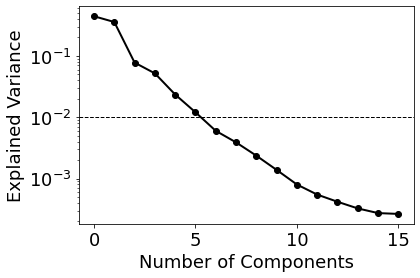

In [24]:
data = np.array(train_data)
d1, d2 = data.shape

pca = decomposition.PCA()
pca.fit(data)

f, ax = plt.subplots(figsize = (6,4))
plt.plot(pca.explained_variance_ratio_[0:16], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of Components', fontsize = 18)
plt.ylabel('Explained Variance', fontsize = 18)
plt.tick_params(labelsize = 18)

#99% line
plt.axhline (0.01, linewidth = 1., linestyle = '--', c = 'black')

plt.yscale('log')

Investigate how peak shift and noise affect the required PCA components for representing 99% of data

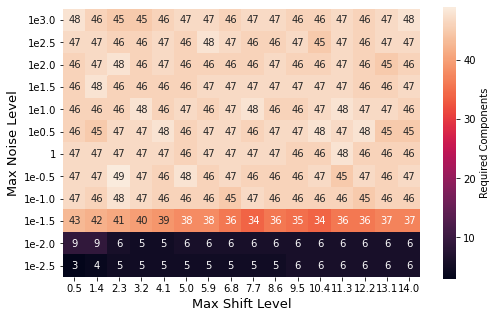

In [25]:
#customize multiple levels of peak shift
mu_level = np.linspace(5,140,16)

#customize multiple levels of noise
ex = np.linspace(3,-2.5,12)
noise_level = np.power(10, ex)

#analyze the required PCA components number for datasets with different levels of peak shift and noise
noise_data = np.zeros((12,16))
mu_data = np.zeros((12,16))
req_comp_number = np.zeros((12,16))
for i in range(12):
  for j in range (16):
    m = int(mu_level[j])
    nl = noise_level[i]
    g_data, _mu, _noise = generate_1Dspectra_mu_noise(mu_level = m, noise_level = nl)
    
    mu_data[i, j] = m
    noise_data[i, j] = nl

    data = np.array(g_data)
    d1, d2 = data.shape

    pca = decomposition.PCA()
    pca.fit(data)
    a = pca.explained_variance_ratio_
    req_comp_number[i,j] = np.argwhere(a > 0.01).max()

#Plot noise level and shift level as a heat map of required_component_number
mu = mu_level/10
mu = mu.tolist()
noise = ['1e3.0', '1e2.5', '1e2.0', '1e1.5', '1e1.0', '1e0.5', '1', '1e-0.5', '1e-1.0', '1e-1.5', '1e-2.0', '1e-2.5']

f, ax = plt.subplots(figsize = (8,5))
ax = sns.heatmap(req_comp_number, xticklabels=mu, yticklabels=noise, annot = True, square = True, cbar_kws={'label':'Required Components'})
ax.set_ylabel ('Max Noise Level', fontsize = 13)
ax.set_xlabel ('Max Shift Level', fontsize = 13)
plt.show()

Do PCA decomposition on the first data set

In [26]:
# the first data set
train_data, mu_real, a_real, sig_real = generate_1Dspectra()

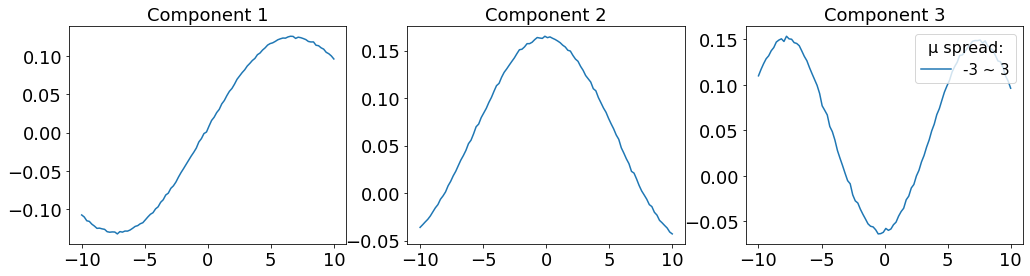

In [27]:
# PCA decomposition
nc = 3   #set component number

x = np.linspace(-10,10,100)
clf = decomposition.PCA(n_components=nc, random_state=42)

data_dec = clf.fit_transform(data)

components = clf.components_

#plot components
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (5.7*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    j = 0
    ax1.plot(x, components[i], label = '-3 ~ 3')
    ax1.set_title('Component ' + str(i + 1), fontsize = 18)
    ax1.tick_params(labelsize = 18)
plt.legend(title = "μ spread:", title_fontsize = 16, fontsize = 15, loc = 'upper right')
plt.subplots_adjust(wspace = 0.22)
plt.show()

Plot the correlation of PCA components and ground truth values

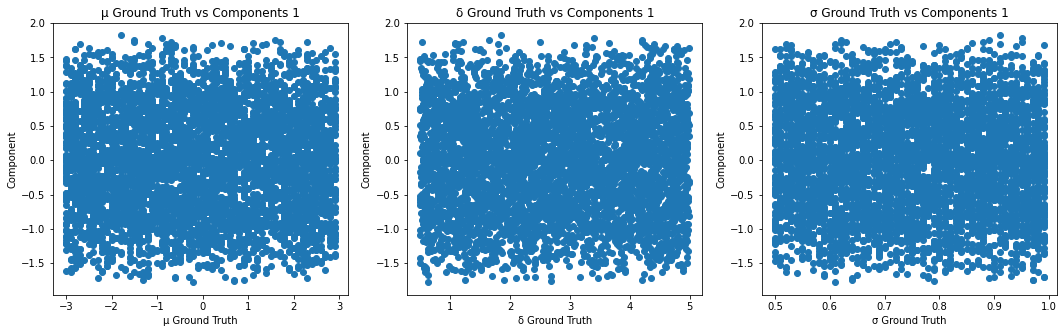

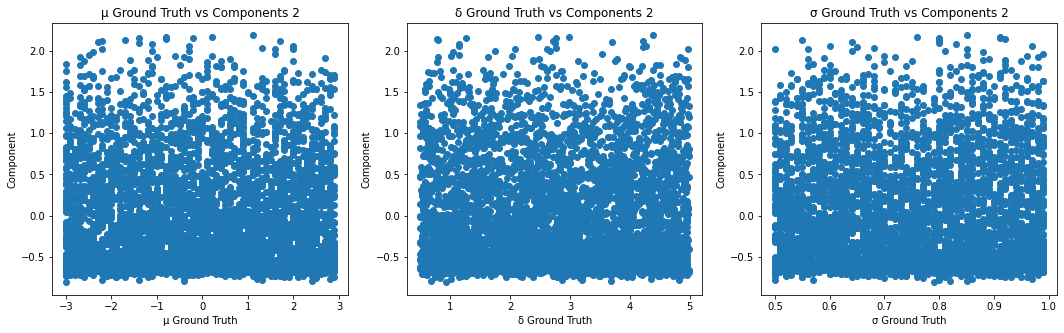

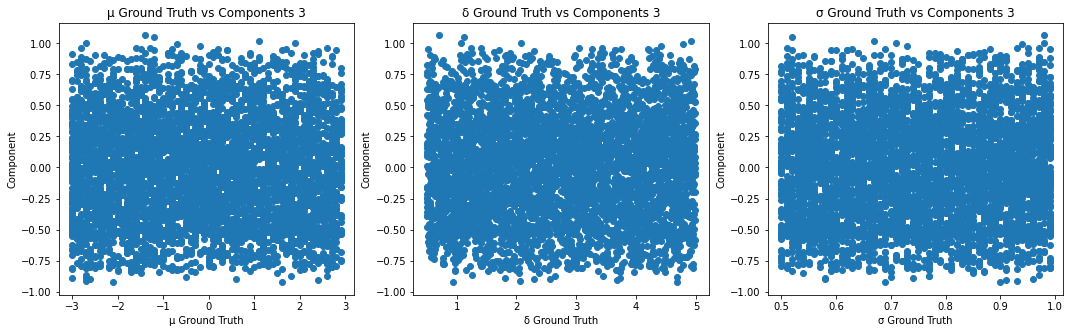

In [28]:
for i in range (3):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 5))
  ax1.scatter (mu_real, data_dec[:,i])
  ax1.set_title('μ Ground Truth vs Components ' + str(i+1))
  ax1.set_xlabel('μ Ground Truth')
  ax1.set_ylabel('Component')
  ax2.scatter (sig_real, data_dec[:,i])
  ax2.set_title('δ Ground Truth vs Components ' + str(i+1))
  ax2.set_xlabel('δ Ground Truth')
  ax2.set_ylabel('Component')
  ax3.scatter (a_real, data_dec[:,i])
  ax3.set_title('σ Ground Truth vs Components ' + str(i+1))
  ax3.set_xlabel('σ Ground Truth')
  ax3.set_ylabel('Component')
  plt.show()

# VAE analysis


*   We do VAE and shift-VAE analyses on the first data set next
*   However, note that users can also use this workflow to analyze other data set by changing the input data






## Initialize train_data

In [29]:
# Generate the first data set
train_data, mu_real, a_real, sig_real = generate_1Dspectra()

# Initialize dataloader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)     #use the desired dataset; here the we use the first data set 'train_data'

Randomly plot some spectra to look at the selected dataset

Text(0.5, 0.92, 'Train Data with Various μ& δ& σ')

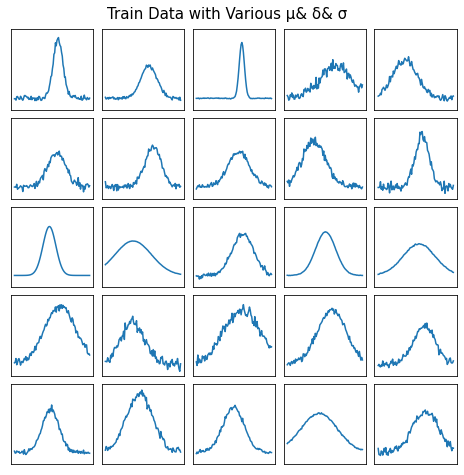

In [30]:
#show spectra
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

x = torch.linspace(-10, 10, 100)
for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x, y[0, 0])
    ax.set_ylim (-0.01,1.01)

fig.suptitle('Train Data with Various μ& δ& σ', fontsize = 15, y = 0.92 )

## Regular VAE train

*   We do regular VAE analyis first



In [31]:
# set the dimension of the spectra
in_dim = (100,)

# Initialize invariant VAE
vae = pv.models.trVAE(in_dim, latent_dim=2, coord=0,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(200):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: -8.7733
Epoch: 2 Training loss: -105.2705
Epoch: 3 Training loss: -108.5858
Epoch: 4 Training loss: -112.4477
Epoch: 5 Training loss: -114.6331
Epoch: 6 Training loss: -115.5816
Epoch: 7 Training loss: -116.2391
Epoch: 8 Training loss: -117.0003
Epoch: 9 Training loss: -117.5511
Epoch: 10 Training loss: -117.9110
Epoch: 11 Training loss: -118.2035
Epoch: 12 Training loss: -118.8328
Epoch: 13 Training loss: -119.1927
Epoch: 14 Training loss: -119.0927
Epoch: 15 Training loss: -119.0534
Epoch: 16 Training loss: -119.5063
Epoch: 17 Training loss: -119.6963
Epoch: 18 Training loss: -119.7033
Epoch: 19 Training loss: -119.9537
Epoch: 20 Training loss: -119.9457
Epoch: 21 Training loss: -120.1523
Epoch: 22 Training loss: -120.2831
Epoch: 23 Training loss: -120.3079
Epoch: 24 Training loss: -120.4291
Epoch: 25 Training loss: -120.4639
Epoch: 26 Training loss: -120.5646
Epoch: 27 Training loss: -120.6165
Epoch: 28 Training loss: -120.6051
Epoch: 29 Training loss: -120.6

### Encode the training data into the latent space:

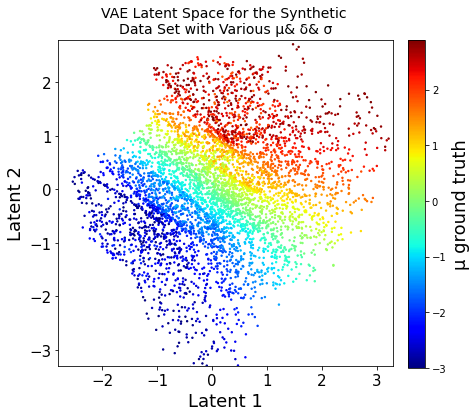

In [32]:
z_mean, z_sd = vae.encode(train_data)   #VAE encode on the first data set, please use the correct dataset

#plot two latent variables as 2D distribution and colored by ground truth peak shift
f, ax = plt.subplots(figsize = (6,6))
ax.scatter(z_mean[:, -2], z_mean[:, -1], s=2, c = mu_real, cmap = 'jet')
ax.set_xlabel('Latent 1', fontsize = 18)
ax.set_ylabel('Latent 2', fontsize = 18)
ax.tick_params(labelsize = 15)
ax.set_xlim(-2.8,3.3)
ax.set_ylim(-3.3, 2.8)
ax.set_title('VAE Latent Space for the Synthetic \nData Set with Various μ& δ& σ', fontsize = 14)

clrbar = np.linspace(mu_real.min(), mu_real.max()).reshape(-1, 1)
ax_ = f.add_axes([.68, .12, .30, .76])
img = plt.imshow(clrbar, cmap = 'jet')
plt.gca().set_visible(False)
clrbar = plt.colorbar(img, ax=ax_, orientation='vertical')
clrbar.set_label('μ ground truth', fontsize=18, labelpad=5)
plt.show()
plt.show()

Check the relationship between ground truth values with VAE latent variables

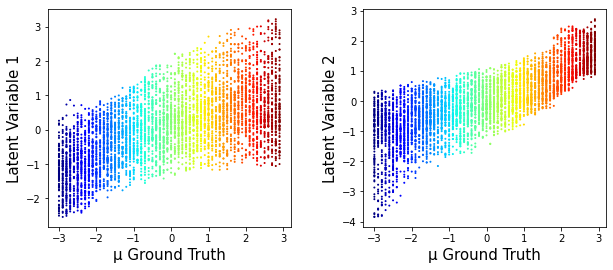

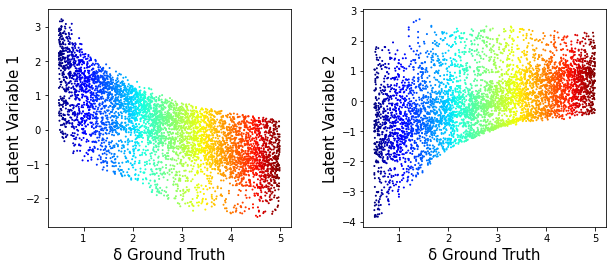

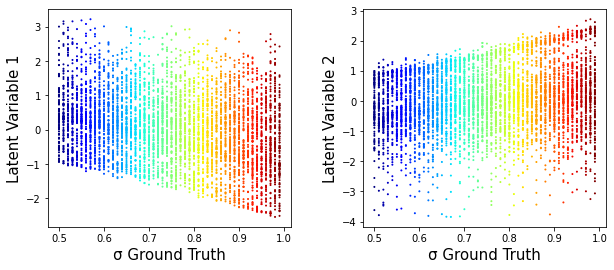

In [33]:
# Compare ground truth shift and VAE latent variables
_, (ax0, ax1) = plt.subplots(1,2, figsize = (10,4))
ax0.scatter(mu_real, z_mean[:,0], c = mu_real, s=1, cmap = 'jet')
ax0.set_ylabel('Latent Variable 1', fontsize = 15)
ax0.set_xlabel('μ Ground Truth', fontsize = 15)
ax1.scatter(mu_real, z_mean[:,1],c = mu_real, s=1, cmap = 'jet')
ax1.set_xlabel('μ Ground Truth', fontsize = 15)
ax1.set_ylabel('Latent Variable 2', fontsize = 15)
plt.subplots_adjust(wspace = 0.3)

# Compare ground truth width and VAE latent variables
_, (ax0, ax1) = plt.subplots(1,2, figsize = (10,4))
ax0.scatter(sig_real, z_mean[:,0], c = sig_real, s=1, cmap = 'jet')
ax0.set_ylabel('Latent Variable 1', fontsize = 15)
ax0.set_xlabel('δ Ground Truth', fontsize = 15)
ax1.scatter(sig_real, z_mean[:,1], c = sig_real, s=1, cmap = 'jet')
ax1.set_xlabel('δ Ground Truth', fontsize = 15)
ax1.set_ylabel('Latent Variable 2', fontsize = 15)
plt.subplots_adjust(wspace = 0.3)

# Compare ground truth intensity and VAE latent variables
_, (ax0, ax1) = plt.subplots(1,2, figsize = (10,4))
ax0.scatter(a_real, z_mean[:,0], c = a_real, s=1, cmap = 'jet')
ax0.set_ylabel('Latent Variable 1', fontsize = 15)
ax0.set_xlabel('σ Ground Truth', fontsize = 15)
ax1.scatter(a_real, z_mean[:,1], c = a_real, s=1, cmap = 'jet')
ax1.set_xlabel('σ Ground Truth', fontsize = 15)
ax1.set_ylabel('Latent Variable 2', fontsize = 15)
plt.subplots_adjust(wspace = 0.3)

### VAE manifold2d

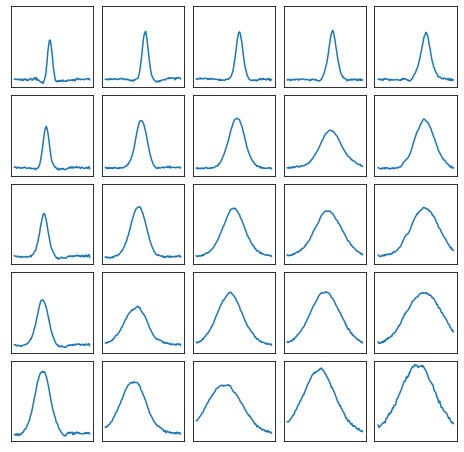

In [34]:
vae.manifold2d(d=5, ylim = [0.05,1]);

## Shift VAE train

*   We do shift-VAE analyis on the first data set now





In [35]:
in_dim = (100,)

# Initialize shift-invariant VAE
svae = pv.models.trVAE(in_dim, latent_dim=2, coord=1,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed= 0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(svae)

# Train for n epochs:
for e in range(200):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 13.4788
Epoch: 2 Training loss: -92.5267
Epoch: 3 Training loss: -105.6365
Epoch: 4 Training loss: -109.7558
Epoch: 5 Training loss: -112.2965
Epoch: 6 Training loss: -113.6470
Epoch: 7 Training loss: -115.7201
Epoch: 8 Training loss: -116.9012
Epoch: 9 Training loss: -117.1508
Epoch: 10 Training loss: -117.5959
Epoch: 11 Training loss: -118.1567
Epoch: 12 Training loss: -118.8556
Epoch: 13 Training loss: -119.3183
Epoch: 14 Training loss: -118.8605
Epoch: 15 Training loss: -119.5009
Epoch: 16 Training loss: -119.7423
Epoch: 17 Training loss: -122.4178
Epoch: 18 Training loss: -123.3492
Epoch: 19 Training loss: -124.0794
Epoch: 20 Training loss: -124.2926
Epoch: 21 Training loss: -124.7078
Epoch: 22 Training loss: -124.6292
Epoch: 23 Training loss: -125.0002
Epoch: 24 Training loss: -125.1304
Epoch: 25 Training loss: -125.3247
Epoch: 26 Training loss: -125.6102
Epoch: 27 Training loss: -125.8374
Epoch: 28 Training loss: -125.7517
Epoch: 29 Training loss: -125.81

### Encode train data into the latent space:

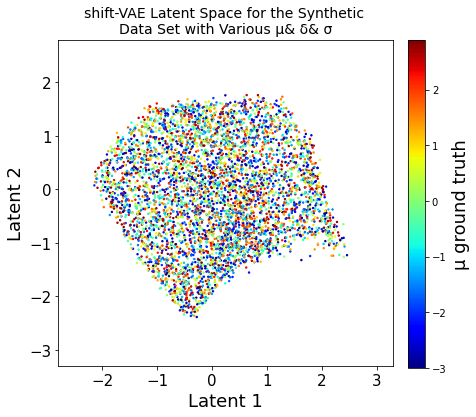

In [36]:
z_mean, z_sd = svae.encode(train_data)   #shift-VAE encode on the first data set, please use the correct dataset

#plot two latent variables as 2D distribution and colored by ground truth peak shift
f, ax = plt.subplots(figsize = (6,6))
ax.scatter(z_mean[:, -2], z_mean[:, -1], s=2, c = mu_real, cmap = 'jet')
ax.set_xlabel('Latent 1', fontsize = 18)
ax.set_ylabel('Latent 2', fontsize = 18)
ax.tick_params(labelsize = 15)
ax.set_xlim(-2.8,3.3)
ax.set_ylim(-3.3, 2.8)
ax.set_title('shift-VAE Latent Space for the Synthetic \nData Set with Various μ& δ& σ', fontsize = 14)

clrbar = np.linspace(mu_real.min(), mu_real.max()).reshape(-1, 1)
ax_ = f.add_axes([.68, .12, .30, .76])
img = plt.imshow(clrbar, cmap = 'jet')
plt.gca().set_visible(False)
clrbar = plt.colorbar(img, ax=ax_, orientation='vertical')
clrbar.set_label('μ ground truth', fontsize=18, labelpad=5)
plt.show()

Check the relationship between ground truth values with shift-VAE latent variables

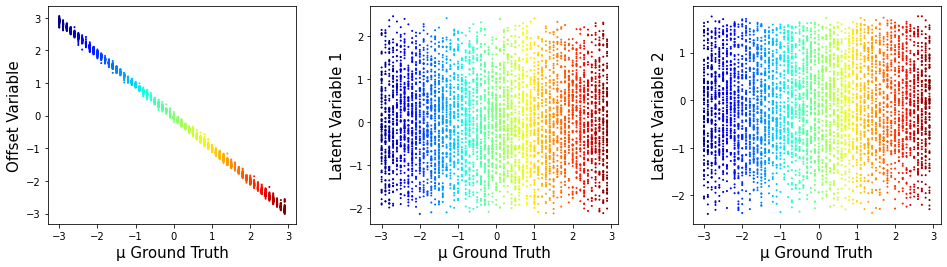

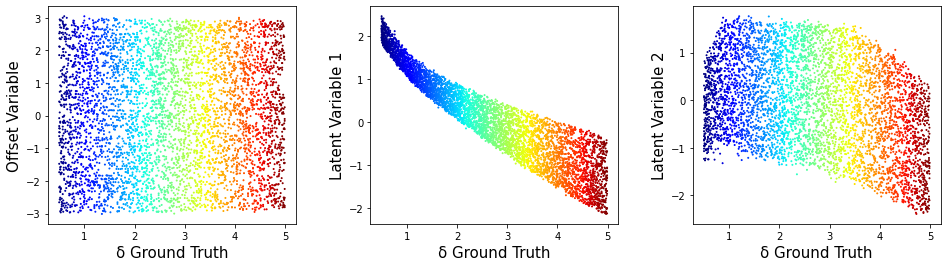

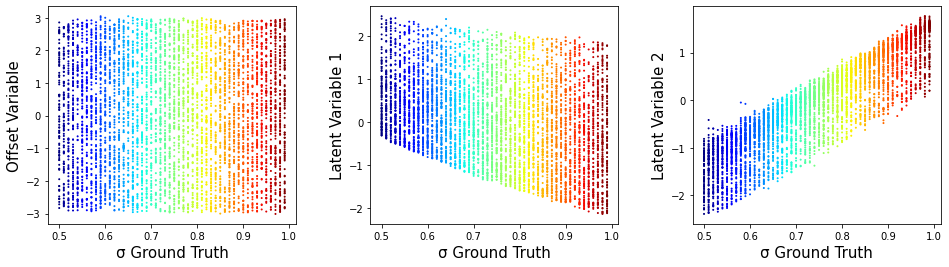

In [37]:
# Compare peak shift and shift-VAE latent variables
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (16,4))
ax0.scatter(mu_real, z_mean[:,0], c = mu_real, s=1, cmap = 'jet')
ax0.set_ylabel('Offset Variable', fontsize = 15)
ax0.set_xlabel('μ Ground Truth', fontsize = 15)
ax1.scatter(mu_real, z_mean[:,1], c = mu_real, s=1, cmap = 'jet')
ax1.set_xlabel('μ Ground Truth', fontsize = 15)
ax1.set_ylabel('Latent Variable 1', fontsize = 15)
ax2.scatter(mu_real, z_mean[:,2], c = mu_real, s=1, cmap = 'jet')
ax2.set_ylabel('Latent Variable 2', fontsize = 15)
ax2.set_xlabel('μ Ground Truth', fontsize = 15)
plt.subplots_adjust(wspace = 0.3)

# Compare peak width and shift-VAE latent variables
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (16,4))
ax0.scatter(sig_real, z_mean[:,0], c = sig_real, s=1, cmap = 'jet')
ax0.set_ylabel('Offset Variable', fontsize = 15)
ax0.set_xlabel('δ Ground Truth', fontsize = 15)
ax1.scatter(sig_real, z_mean[:,1], c = sig_real, s=1, cmap = 'jet')
ax1.set_xlabel('δ Ground Truth', fontsize = 15)
ax1.set_ylabel('Latent Variable 1', fontsize = 15)
ax2.scatter(sig_real, z_mean[:,2], c = sig_real, s=1, cmap = 'jet')
ax2.set_ylabel('Latent Variable 2', fontsize = 15)
ax2.set_xlabel('δ Ground Truth', fontsize = 15)
plt.subplots_adjust(wspace = 0.3)

# Compare peak intensity and shift-VAE latent variables
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (16,4))
ax0.scatter(a_real, z_mean[:,0], c = a_real, s=1, cmap = 'jet')
#ax0.set_ylabel('σ Encoded', fontsize = 15)
ax0.set_ylabel('Offset Variable', fontsize = 15)
ax0.set_xlabel('σ Ground Truth', fontsize = 15)
ax1.scatter(a_real, z_mean[:,1], c = a_real, s=1, cmap = 'jet')
ax1.set_xlabel('σ Ground Truth', fontsize = 15)
ax1.set_ylabel('Latent Variable 1', fontsize = 15)
ax2.scatter(a_real, z_mean[:,2], c = a_real, s=1, cmap = 'jet')
ax2.set_ylabel('Latent Variable 2', fontsize = 15)
ax2.set_xlabel('σ Ground Truth', fontsize = 15)
plt.subplots_adjust(wspace = 0.3)

### Shift-VAE manifold2d

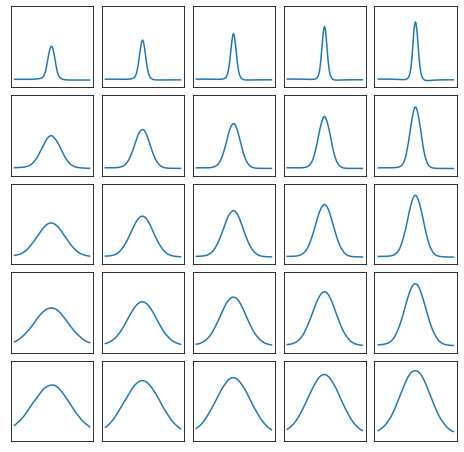

In [38]:
svae.manifold2d(d=5, ylim = [0.05,1]);

# Decode raw data: vae vs shift-vae


*   Next, we first use the trained VAE and shift-VAE models to decode the raw data set
*   Then, we fit the decoded spectra to obtain their shift, width, and intensity
*   Finally, we compare the decoded parameters with the ground truth values to check the analysis qualities of VAE and shift-VAE





Define a decode and fit function: decode_paras. This function decodes the data and directly returns fitted peak parameters

In [ ]:
#@title Define Decode Function: click to show code       
def gauss(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

def decode_paras (f, train_data):
  gmodel = Model(gauss)
  decoded_peak = np.zeros((len(train_data),3))
  z_mean, _ = f.encode(train_data)
  x = np.linspace (-10,10,100)

  for i in range (len(train_data)):
    deco = torch.tensor([z_mean[i,-2],z_mean[i,-1]])[None]
    d=f.decode(deco).cpu()

    y = np.array(d[0])

    mx = y.max()
    height = y.max()-y.min()

    y = (y-y.min())/height

    a = y.max()
    # center = np.float(x[np.where(y == a)])
    c = sum(x * y) / sum(y)
    w = np.sqrt(sum(y * (x - c)**2) / sum(y))

    params = gmodel.make_params(cen=c, amp=a, wid=w)
    result = gmodel.fit(y, params, x=x)

    para=result.fit_report()
    idx_amp = para.index('amp')
    d_am = para[idx_amp+6:idx_amp+16]
    d_amp = np.float(d_am)

    idx_mu = para.index('cen')
    d_m = para[idx_mu+6:idx_mu+16]
    d_mu = np.float(d_m)

    idx_w = para.index('wid')
    d_s = para[idx_w+6:idx_w+16]
    d_sig = np.float(d_s)

    d_a = d_amp / (sqrt(2*pi) * d_sig) * mx
    decoded_peak [i,] = d_a, d_mu, d_sig   #0: intensity, 1: mu, 2, sig
  return decoded_peak  

In [ ]:
#VAE decode
decode_peaks_vae = decode_paras(vae, train_data)   #Paremeters of VAE decoded peak are saved here, 0: peak intensity; 1: peak shift; 2: peak width

#compare the decoded parameters with ground truth values
q_diff_vae = np.zeros_like (decode_peaks_vae)
q_diff_vae[:,0] = decode_peaks_vae[:,0]-np.array(a_real)     #calculate the error of decoded intensity 
q_diff_vae[:,1] = decode_peaks_vae[:,1]-np.array(mu_real)    #calculate the error of decoded shift 
q_diff_vae[:,2] = decode_peaks_vae[:,2]-np.array(sig_real)   #calculate the error of decoded width 



#shift-VAE decode
decode_peaks_svae = decode_paras(svae, train_data)     #Paremeters of shift-VAE decoded peak are saved here, 0: peak intensity; 1: peak shift; 2: peak width

#compare the decoded parameters with ground truth values 
q_diff_svae = np.zeros_like (decode_peaks_svae)
q_diff_svae[:,0] = decode_peaks_svae[:,0]-np.array(a_real)     #calculate the error of decoded intensity 
q_diff_svae[:,1] = decode_peaks_svae[:,1]                      #calculate the error of decoded shift 
q_diff_svae[:,2] = decode_peaks_svae[:,2]-np.array(sig_real)   #calculate the error of decoded width 

Compare the quality of VAE and shift-VAE via showing the error distribution in 2D hist map

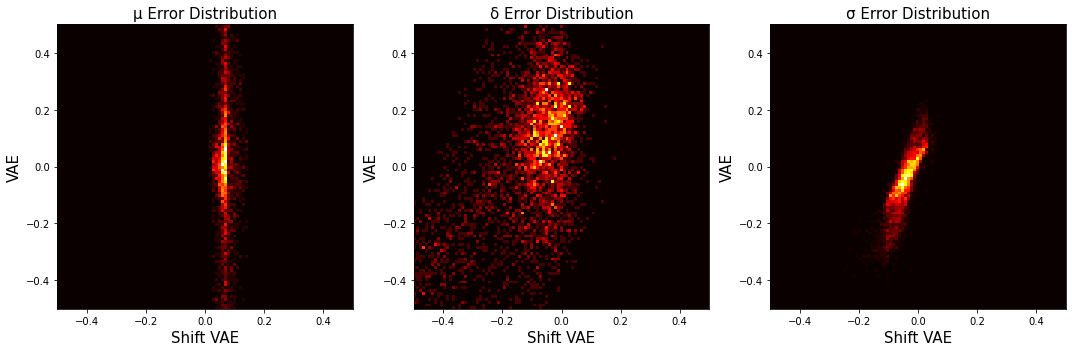

In [ ]:
fontsize = 15
f, (ax1, ax2, ax3) = plt.subplots (1,3, figsize = (15,5))

ax1.hist2d(q_diff_svae[:,1], q_diff_vae[:,1], bins = np.linspace(-0.5,0.5,100), cmap = 'hot');
ax1.set_xlabel ('Shift VAE', fontsize = fontsize)
ax1.set_ylabel ('VAE', fontsize = fontsize)
ax1.set_title('μ Error Distribution', fontsize = fontsize)

ax2.hist2d(q_diff_svae[:,2], q_diff_vae[:,2], bins = np.linspace(-0.5,0.5,100), cmap = 'hot');
ax2.set_xlabel ('Shift VAE', fontsize = fontsize)
ax2.set_ylabel ('VAE', fontsize = fontsize)
ax2.set_title('δ Error Distribution', fontsize = fontsize)

ax3.hist2d(q_diff_svae[:,0], q_diff_vae[:,0], bins = np.linspace(-0.5,0.5,100), cmap = 'hot');
ax3.set_xlabel ('Shift VAE', fontsize = fontsize)
ax3.set_ylabel ('VAE', fontsize = fontsize)
ax3.set_title('σ Error Distribution', fontsize = fontsize)

plt.tight_layout()

# Latent Space Descriptors: VAE vs shift-VAE


*   Here, we define physical-relavant descriptors and convert the latent manifold2D to these descriptor
*   This allows the visualization of physical-relavant informaiton in latent space



Plot VAE and shift-VAE manifold2D with a larger grid number

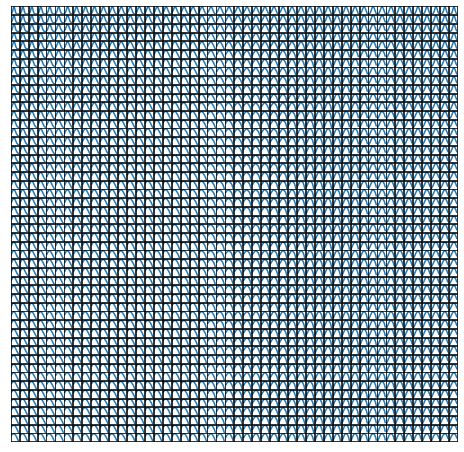

In [ ]:
n = 50   #grid number
f_vae = vae.manifold2d(d = n)
f_svae = svae.manifold2d(d = n)

Define a function to extract the parameters of the peaks in manifold2D. 
This function can direct return peak intensity map, peak shift map, and peak width map

In [ ]:
#@title Define Latent_Space_Spectra_Parameters Functiona: clike to show code
def gauss(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))

def ls_parameters(f, n):         #f: manifold2d; n: grid number
  x = np.linspace (-10,10,100)
  gmodel = Model(gauss)
  latent_peak = np.zeros((n*n, 3))

  for i in range (n*n):
    y = np.array(f[i])
    mx = y.max()
    y = (y-y.min())/(y.max()-y.min())
    
    a = y.max()
    #center = np.float(x[np.where(y == a)])
    c = sum(x * y) / sum(y)
    w = np.sqrt(sum(y * (x - c)**2) / sum(y))

    params = gmodel.make_params(cen=c, amp=a, wid=w)
    result = gmodel.fit(y, params, x=x)

    para=result.fit_report()
    idx_amp = para.index('amp')
    d_am = para[idx_amp+6:idx_amp+16]
    d_amp = np.float(d_am)

    idx_mu = para.index('cen')
    d_m = para[idx_mu+6:idx_mu+16]
    d_mu = np.float(d_m)

    idx_w = para.index('wid')
    d_s = para[idx_w+6:idx_w+16]
    d_sig = np.float(d_s)

    d_a = d_amp / (sqrt(2*pi) * d_sig) * mx
    latent_peak [i,] = d_a, d_mu, d_sig
  
  l_a = latent_peak[:,0] 
  a_map = np.reshape(l_a, (n,n))
  l_mu = latent_peak[:,1] 
  mu_map = np.reshape(l_mu, (n,n))
  l_sig = latent_peak[:,2] 
  sig_map = np.reshape(l_sig, (n,n))

  return a_map, mu_map, sig_map

Use the defined function to analyze VAE manifold2D

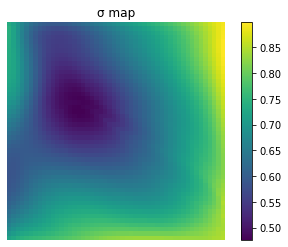

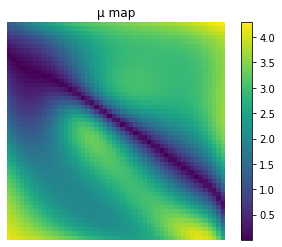

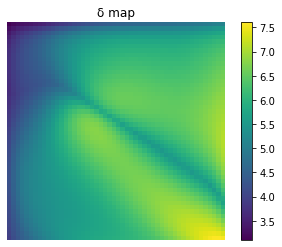

In [ ]:
#vae latent space
a_map, mu_map, sig_map = ls_parameters(f_vae, n = n)     #input VAE manifold2D and grid number to the function ls_parameters and return intensity, shift, and width maps

#plt intensity, shift, and width maps
plt.imshow(a_map)
plt.axis('off')
plt.title ('σ map')
plt.colorbar()
plt.show()

plt.imshow(mu_map)
plt.axis('off')
plt.title ('μ map')
plt.colorbar()
plt.show()

plt.imshow(sig_map)
plt.axis('off')
plt.title ('δ map')
plt.colorbar()
plt.show()

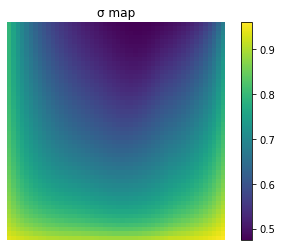

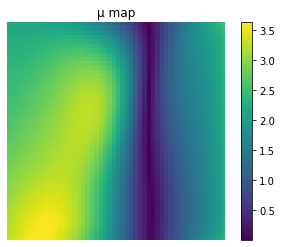

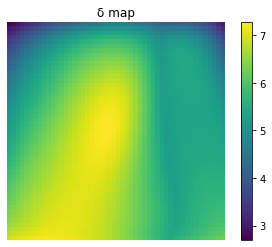

In [ ]:
#svae latent space
a_map, mu_map, sig_map = ls_parameters(f_svae, n = n)#input VAE manifold2D and grid number to the function ls_parameters and return intensity, shift, and width maps

#plt intensity, shift, and width maps
plt.imshow(a_map)
plt.axis('off')
plt.title ('σ map')
plt.colorbar()
plt.show()

plt.imshow(mu_map)
plt.axis('off')
plt.title ('μ map')
plt.colorbar()
plt.show()

plt.imshow(sig_map)
plt.axis('off')
plt.title ('δ map')
plt.colorbar()
plt.show()

# Use trained VAE and shift-VAE models on datasets with customized shift and width

Generate 13 spectra data sets with peak shift from -6 to 6

In [ ]:
#@title Define Function to generate spectra with customized shift: click to show code
#define function to generate spectra with contrallable mu
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))
def generate_1Dspectra_mu(nsamples: int = 5000, mu_real= 0) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                           
    dataset = []
    sig_real = []
    a_real = []

    for _ in range(nsamples):
        noise = torch.randint(0, 50, (1,)) / 1e3              
        mu = torch.tensor(mu_real)            
        sig = torch.randint(50, 500, size=(1,)) / 1e2           
        a = torch.randint(50,100, size=(1,)) / 100             
                                         
        g = a*gaussian(x, mu, sig) + noise * torch.randn(size=(len(x),))

        dataset.append(g[None, ...])
        sig_real.append(sig)
        a_real.append(a)

    dataset = torch.cat(dataset)
    sig_real = torch.cat(sig_real)
    a_real = torch.cat(a_real)

    dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
    return dataset, mu_real, a_real, sig_real

In [ ]:
#@title Generate 13 spectra datasets with shift from -6 to 6: click to show code
train_data_n6, mu_real_n6, a_real_n6, sig_real_n6 = generate_1Dspectra_mu(mu_real = -6)
train_loader_n6 = pv.utils.init_dataloader(train_data_n6.unsqueeze(1), batch_size=64)

train_data_n5, mu_real_n5, a_real_n5, sig_real_n5 = generate_1Dspectra_mu(mu_real = -5)
train_loader_n5 = pv.utils.init_dataloader(train_data_n5.unsqueeze(1), batch_size=64)

train_data_n4, mu_real_n4, a_real_n4, sig_real_n4 = generate_1Dspectra_mu(mu_real = -4)
train_loader_n4 = pv.utils.init_dataloader(train_data_n4.unsqueeze(1), batch_size=64)

train_data_n3, mu_real_n3, a_real_n3, sig_real_n3 = generate_1Dspectra_mu(mu_real = -3)
train_loader_n3 = pv.utils.init_dataloader(train_data_n3.unsqueeze(1), batch_size=64)

train_data_n2, mu_real_n2, a_real_n2, sig_real_n2 = generate_1Dspectra_mu(mu_real = -2)
train_loader_n2 = pv.utils.init_dataloader(train_data_n2.unsqueeze(1), batch_size=64)

train_data_n1, mu_real_n1, a_real_n1, sig_real_n1 = generate_1Dspectra_mu(mu_real = -1)
train_loader_n1 = pv.utils.init_dataloader(train_data_n1.unsqueeze(1), batch_size=64)

train_data_0, mu_real_0, a_real_0, sig_real_0 = generate_1Dspectra_mu(mu_real = 0)
train_loader_0 = pv.utils.init_dataloader(train_data_0.unsqueeze(1), batch_size=64)

train_data_6, mu_real_6, a_real_6, sig_real_6 = generate_1Dspectra_mu(mu_real = 6)
train_loader_6 = pv.utils.init_dataloader(train_data_6.unsqueeze(1), batch_size=64)

train_data_5, mu_real_5, a_real_5, sig_real_5 = generate_1Dspectra_mu(mu_real = 5)
train_loader_5 = pv.utils.init_dataloader(train_data_5.unsqueeze(1), batch_size=64)

train_data_4, mu_real_4, a_real_4, sig_real_4 = generate_1Dspectra_mu(mu_real = 4)
train_loader_4 = pv.utils.init_dataloader(train_data_4.unsqueeze(1), batch_size=64)

train_data_3, mu_real_3, a_real_3, sig_real_3 = generate_1Dspectra_mu(mu_real = 3)
train_loader_3 = pv.utils.init_dataloader(train_data_3.unsqueeze(1), batch_size=64)

train_data_2, mu_real_2, a_real_2, sig_real_2 = generate_1Dspectra_mu(mu_real = 2)
train_loader_2 = pv.utils.init_dataloader(train_data_2.unsqueeze(1), batch_size=64)

train_data_1, mu_real_1, a_real_1, sig_real_1 = generate_1Dspectra_mu(mu_real = 1)
train_loader_1 = pv.utils.init_dataloader(train_data_1.unsqueeze(1), batch_size=64)

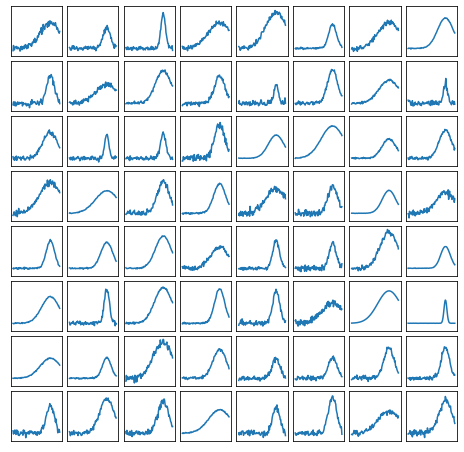

In [ ]:
#let us look at these dataset
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

x = torch.linspace(-10, 10, 100)
for ax, (y,) in zip(axes.flat, train_loader_6):   #select the dataset want to look at
    ax.plot(x, y[0, 0])
    ax.set_ylim (-0.01,1.01)

Decode these datasets by VAE model and shift-VAE model, respectively

In [ ]:
#@title Decode 13 datasets with different shift by VAE model:click to show code
#vae decode
vae_decode_peaks_mu_0 = decode_paras(vae, train_data_0)
vae_decode_peaks_mu_1 = decode_paras(vae, train_data_1)
vae_decode_peaks_mu_2 = decode_paras(vae, train_data_2)
vae_decode_peaks_mu_3 = decode_paras(vae, train_data_3)
vae_decode_peaks_mu_4 = decode_paras(vae, train_data_4)
vae_decode_peaks_mu_5 = decode_paras(vae, train_data_5)
vae_decode_peaks_mu_6 = decode_paras(vae, train_data_6)
vae_decode_peaks_mu_n1 = decode_paras(vae, train_data_n1)
vae_decode_peaks_mu_n2 = decode_paras(vae, train_data_n2)
vae_decode_peaks_mu_n3 = decode_paras(vae, train_data_n3)
vae_decode_peaks_mu_n4 = decode_paras(vae, train_data_n4)
vae_decode_peaks_mu_n5 = decode_paras(vae, train_data_n5)
vae_decode_peaks_mu_n6 = decode_paras(vae, train_data_n6)

In [ ]:
#@title Decode 13 datasets with different shift by shift-VAE model: click to show code
#svae decode
svae_decode_peaks_mu_0 = decode_paras(svae, train_data_0)
svae_decode_peaks_mu_1 = decode_paras(svae, train_data_1)
svae_decode_peaks_mu_2 = decode_paras(svae, train_data_2)
svae_decode_peaks_mu_3 = decode_paras(svae, train_data_3)
svae_decode_peaks_mu_4 = decode_paras(svae, train_data_4)
svae_decode_peaks_mu_5 = decode_paras(svae, train_data_5)
svae_decode_peaks_mu_6 = decode_paras(svae, train_data_6)
svae_decode_peaks_mu_n1 = decode_paras(svae, train_data_n1)
svae_decode_peaks_mu_n2 = decode_paras(svae, train_data_n2)
svae_decode_peaks_mu_n3 = decode_paras(svae, train_data_n3)
svae_decode_peaks_mu_n4 = decode_paras(svae, train_data_n4)
svae_decode_peaks_mu_n5 = decode_paras(svae, train_data_n5)
svae_decode_peaks_mu_n6 = decode_paras(svae, train_data_n6)

Then, we check the errors produced by VAE decode process and shift-VAE decode process

In [ ]:
#@title Calculate VAE and Shift-VAE decode errors on these 13 datasets: click to show code
#vae
vae_q_diff_mu_0 = np.zeros_like (vae_decode_peaks_mu_0)
vae_q_diff_mu_0[:,0] = vae_decode_peaks_mu_0[:,0]-np.array(a_real_0)
vae_q_diff_mu_0[:,1] = vae_decode_peaks_mu_0[:,1]-mu_real_0
vae_q_diff_mu_0[:,2] = vae_decode_peaks_mu_0[:,2]-np.array(sig_real_0)

vae_q_diff_mu_1 = np.zeros_like (vae_decode_peaks_mu_1)
vae_q_diff_mu_1[:,0] = vae_decode_peaks_mu_1[:,0]-np.array(a_real_1)
vae_q_diff_mu_1[:,1] = vae_decode_peaks_mu_1[:,1]-mu_real_1
vae_q_diff_mu_1[:,2] = vae_decode_peaks_mu_1[:,2]-np.array(sig_real_1)

vae_q_diff_mu_2 = np.zeros_like (vae_decode_peaks_mu_2)
vae_q_diff_mu_2[:,0] = vae_decode_peaks_mu_2[:,0]-np.array(a_real_2)
vae_q_diff_mu_2[:,1] = vae_decode_peaks_mu_2[:,1]-mu_real_2
vae_q_diff_mu_2[:,2] = vae_decode_peaks_mu_2[:,2]-np.array(sig_real_2)

vae_q_diff_mu_3 = np.zeros_like (vae_decode_peaks_mu_3)
vae_q_diff_mu_3[:,0] = vae_decode_peaks_mu_3[:,0]-np.array(a_real_3)
vae_q_diff_mu_3[:,1] = vae_decode_peaks_mu_3[:,1]-mu_real_3
vae_q_diff_mu_3[:,2] = vae_decode_peaks_mu_3[:,2]-np.array(sig_real_3)

vae_q_diff_mu_4 = np.zeros_like (vae_decode_peaks_mu_4)
vae_q_diff_mu_4[:,0] = vae_decode_peaks_mu_4[:,0]-np.array(a_real_4)
vae_q_diff_mu_4[:,1] = vae_decode_peaks_mu_4[:,1]-mu_real_4
vae_q_diff_mu_4[:,2] = vae_decode_peaks_mu_4[:,2]-np.array(sig_real_4)

vae_q_diff_mu_5 = np.zeros_like (vae_decode_peaks_mu_5)
vae_q_diff_mu_5[:,0] = vae_decode_peaks_mu_5[:,0]-np.array(a_real_5)
vae_q_diff_mu_5[:,1] = vae_decode_peaks_mu_5[:,1]-mu_real_5
vae_q_diff_mu_5[:,2] = vae_decode_peaks_mu_5[:,2]-np.array(sig_real_5)

vae_q_diff_mu_6 = np.zeros_like (vae_decode_peaks_mu_6)
vae_q_diff_mu_6[:,0] = vae_decode_peaks_mu_6[:,0]-np.array(a_real_6)
vae_q_diff_mu_6[:,1] = vae_decode_peaks_mu_6[:,1]-mu_real_6
vae_q_diff_mu_6[:,2] = vae_decode_peaks_mu_6[:,2]-np.array(sig_real_6)

vae_q_diff_mu_n1 = np.zeros_like (vae_decode_peaks_mu_n1)
vae_q_diff_mu_n1[:,0] = vae_decode_peaks_mu_n1[:,0]-np.array(a_real_n1)
vae_q_diff_mu_n1[:,1] = vae_decode_peaks_mu_n1[:,1]-mu_real_n1
vae_q_diff_mu_n1[:,2] = vae_decode_peaks_mu_n1[:,2]-np.array(sig_real_n1)

vae_q_diff_mu_n2 = np.zeros_like (vae_decode_peaks_mu_n2)
vae_q_diff_mu_n2[:,0] = vae_decode_peaks_mu_n2[:,0]-np.array(a_real_n2)
vae_q_diff_mu_n2[:,1] = vae_decode_peaks_mu_n2[:,1]-mu_real_n2
vae_q_diff_mu_n2[:,2] = vae_decode_peaks_mu_n2[:,2]-np.array(sig_real_n2)

vae_q_diff_mu_n3 = np.zeros_like (vae_decode_peaks_mu_n3)
vae_q_diff_mu_n3[:,0] = vae_decode_peaks_mu_n3[:,0]-np.array(a_real_n3)
vae_q_diff_mu_n3[:,1] = vae_decode_peaks_mu_n3[:,1]-mu_real_n3
vae_q_diff_mu_n3[:,2] = vae_decode_peaks_mu_n3[:,2]-np.array(sig_real_n3)

vae_q_diff_mu_n4 = np.zeros_like (vae_decode_peaks_mu_n4)
vae_q_diff_mu_n4[:,0] = vae_decode_peaks_mu_n4[:,0]-np.array(a_real_n4)
vae_q_diff_mu_n4[:,1] = vae_decode_peaks_mu_n4[:,1]-mu_real_n4
vae_q_diff_mu_n4[:,2] = vae_decode_peaks_mu_n4[:,2]-np.array(sig_real_n4)

vae_q_diff_mu_n5 = np.zeros_like (vae_decode_peaks_mu_n5)
vae_q_diff_mu_n5[:,0] = vae_decode_peaks_mu_n5[:,0]-np.array(a_real_n5)
vae_q_diff_mu_n5[:,1] = vae_decode_peaks_mu_n5[:,1]-mu_real_n5
vae_q_diff_mu_n5[:,2] = vae_decode_peaks_mu_n5[:,2]-np.array(sig_real_n5)

vae_q_diff_mu_n6 = np.zeros_like (vae_decode_peaks_mu_n6)
vae_q_diff_mu_n6[:,0] = vae_decode_peaks_mu_n6[:,0]-np.array(a_real_n6)
vae_q_diff_mu_n6[:,1] = vae_decode_peaks_mu_n6[:,1]-mu_real_n6
vae_q_diff_mu_n6[:,2] = vae_decode_peaks_mu_n6[:,2]-np.array(sig_real_n6)

#calculate error = difference between decoded peak and real peak
#svae
svae_q_diff_mu_0 = np.zeros_like (svae_decode_peaks_mu_0)
svae_q_diff_mu_0[:,0] = svae_decode_peaks_mu_0[:,0]-np.array(a_real_0)
svae_q_diff_mu_0[:,1] = svae_decode_peaks_mu_0[:,1]-0
svae_q_diff_mu_0[:,2] = svae_decode_peaks_mu_0[:,2]-np.array(sig_real_0)

svae_q_diff_mu_1 = np.zeros_like (svae_decode_peaks_mu_1)
svae_q_diff_mu_1[:,0] = svae_decode_peaks_mu_1[:,0]-np.array(a_real_1)
svae_q_diff_mu_1[:,1] = svae_decode_peaks_mu_1[:,1]-0
svae_q_diff_mu_1[:,2] = svae_decode_peaks_mu_1[:,2]-np.array(sig_real_1)

svae_q_diff_mu_2 = np.zeros_like (svae_decode_peaks_mu_2)
svae_q_diff_mu_2[:,0] = svae_decode_peaks_mu_2[:,0]-np.array(a_real_2)
svae_q_diff_mu_2[:,1] = svae_decode_peaks_mu_2[:,1]-0
svae_q_diff_mu_2[:,2] = svae_decode_peaks_mu_2[:,2]-np.array(sig_real_2)

svae_q_diff_mu_3 = np.zeros_like (svae_decode_peaks_mu_3)
svae_q_diff_mu_3[:,0] = svae_decode_peaks_mu_3[:,0]-np.array(a_real_3)
svae_q_diff_mu_3[:,1] = svae_decode_peaks_mu_3[:,1]-0
svae_q_diff_mu_3[:,2] = svae_decode_peaks_mu_3[:,2]-np.array(sig_real_3)

svae_q_diff_mu_4 = np.zeros_like (svae_decode_peaks_mu_4)
svae_q_diff_mu_4[:,0] = svae_decode_peaks_mu_4[:,0]-np.array(a_real_4)
svae_q_diff_mu_4[:,1] = svae_decode_peaks_mu_4[:,1]-0
svae_q_diff_mu_4[:,2] = svae_decode_peaks_mu_4[:,2]-np.array(sig_real_4)

svae_q_diff_mu_5 = np.zeros_like (svae_decode_peaks_mu_5)
svae_q_diff_mu_5[:,0] = svae_decode_peaks_mu_5[:,0]-np.array(a_real_5)
svae_q_diff_mu_5[:,1] = svae_decode_peaks_mu_5[:,1]-0
svae_q_diff_mu_5[:,2] = svae_decode_peaks_mu_5[:,2]-np.array(sig_real_5)

svae_q_diff_mu_6 = np.zeros_like (svae_decode_peaks_mu_6)
svae_q_diff_mu_6[:,0] = svae_decode_peaks_mu_6[:,0]-np.array(a_real_6)
svae_q_diff_mu_6[:,1] = svae_decode_peaks_mu_6[:,1]-0
svae_q_diff_mu_6[:,2] = svae_decode_peaks_mu_6[:,2]-np.array(sig_real_6)

svae_q_diff_mu_n1 = np.zeros_like (svae_decode_peaks_mu_n1)
svae_q_diff_mu_n1[:,0] = svae_decode_peaks_mu_n1[:,0]-np.array(a_real_n1)
svae_q_diff_mu_n1[:,1] = svae_decode_peaks_mu_n1[:,1]-0
svae_q_diff_mu_n1[:,2] = svae_decode_peaks_mu_n1[:,2]-np.array(sig_real_n1)

svae_q_diff_mu_n2 = np.zeros_like (svae_decode_peaks_mu_n2)
svae_q_diff_mu_n2[:,0] = svae_decode_peaks_mu_n2[:,0]-np.array(a_real_n2)
svae_q_diff_mu_n2[:,1] = svae_decode_peaks_mu_n2[:,1]-0
svae_q_diff_mu_n2[:,2] = svae_decode_peaks_mu_n2[:,2]-np.array(sig_real_n2)

svae_q_diff_mu_n3 = np.zeros_like (svae_decode_peaks_mu_n3)
svae_q_diff_mu_n3[:,0] = svae_decode_peaks_mu_n3[:,0]-np.array(a_real_n3)
svae_q_diff_mu_n3[:,1] = svae_decode_peaks_mu_n3[:,1]-0
svae_q_diff_mu_n3[:,2] = svae_decode_peaks_mu_n3[:,2]-np.array(sig_real_n3)

svae_q_diff_mu_n4 = np.zeros_like (svae_decode_peaks_mu_n4)
svae_q_diff_mu_n4[:,0] = svae_decode_peaks_mu_n4[:,0]-np.array(a_real_n4)
svae_q_diff_mu_n4[:,1] = svae_decode_peaks_mu_n4[:,1]-0
svae_q_diff_mu_n4[:,2] = svae_decode_peaks_mu_n4[:,2]-np.array(sig_real_n4)

svae_q_diff_mu_n5 = np.zeros_like (svae_decode_peaks_mu_n5)
svae_q_diff_mu_n5[:,0] = svae_decode_peaks_mu_n5[:,0]-np.array(a_real_n5)
svae_q_diff_mu_n5[:,1] = svae_decode_peaks_mu_n5[:,1]-0
svae_q_diff_mu_n5[:,2] = svae_decode_peaks_mu_n5[:,2]-np.array(sig_real_n5)

svae_q_diff_mu_n6 = np.zeros_like (svae_decode_peaks_mu_n6)
svae_q_diff_mu_n6[:,0] = svae_decode_peaks_mu_n6[:,0]-np.array(a_real_n6)
svae_q_diff_mu_n6[:,1] = svae_decode_peaks_mu_n6[:,1]-0
svae_q_diff_mu_n6[:,2] = svae_decode_peaks_mu_n6[:,2]-np.array(sig_real_n6)

Plot the errors produced by VAE and shift-VAE decode process as a function of the ground truth shifts of each data sets.

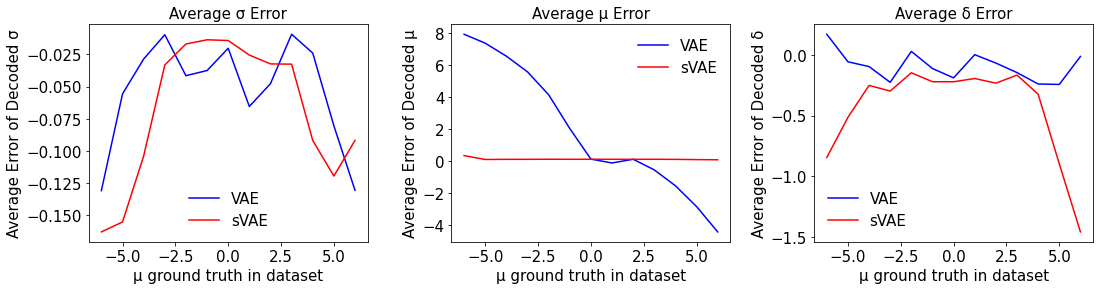

In [ ]:
mureal = ( -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6)

#error in peak shift
i = 1
vae_ave_diff_mu = (vae_q_diff_mu_n6[:,i].mean(), vae_q_diff_mu_n5[:,i].mean(), vae_q_diff_mu_n4[:,i].mean(), vae_q_diff_mu_n3[:,i].mean(), vae_q_diff_mu_n2[:,i].mean(), vae_q_diff_mu_n1[:,i].mean(), 
                   vae_q_diff_mu_0[:,i].mean(), vae_q_diff_mu_1[:,i].mean(), vae_q_diff_mu_2[:,i].mean(), vae_q_diff_mu_3[:,i].mean(), vae_q_diff_mu_4[:,i].mean(), vae_q_diff_mu_5[:,i].mean(), vae_q_diff_mu_6[:,i].mean())
svae_ave_diff_mu = (svae_q_diff_mu_n6[:,i].mean(), svae_q_diff_mu_n5[:,i].mean(), svae_q_diff_mu_n4[:,i].mean(), svae_q_diff_mu_n3[:,i].mean(), svae_q_diff_mu_n2[:,i].mean(),svae_q_diff_mu_n1[:,i].mean(), 
                    svae_q_diff_mu_0[:,i].mean(), svae_q_diff_mu_1[:,i].mean(),svae_q_diff_mu_2[:,i].mean(), svae_q_diff_mu_3[:,i].mean(), svae_q_diff_mu_4[:,i].mean(), svae_q_diff_mu_5[:,i].mean(), svae_q_diff_mu_6[:,i].mean())

#error in peak intensity
i = 0
vae_ave_diff_a = (vae_q_diff_mu_n6[:,i].mean(), vae_q_diff_mu_n5[:,i].mean(), vae_q_diff_mu_n4[:,i].mean(), vae_q_diff_mu_n3[:,i].mean(), vae_q_diff_mu_n2[:,i].mean(),vae_q_diff_mu_n1[:,i].mean(), vae_q_diff_mu_0[:,i].mean(), 
                  vae_q_diff_mu_1[:,i].mean(),vae_q_diff_mu_2[:,i].mean(), vae_q_diff_mu_3[:,i].mean(), vae_q_diff_mu_4[:,i].mean(), vae_q_diff_mu_5[:,i].mean(), vae_q_diff_mu_6[:,i].mean())
svae_ave_diff_a = (svae_q_diff_mu_n6[:,i].mean(), svae_q_diff_mu_n5[:,i].mean(), svae_q_diff_mu_n4[:,i].mean(), svae_q_diff_mu_n3[:,i].mean(), svae_q_diff_mu_n2[:,i].mean(),svae_q_diff_mu_n1[:,i].mean(), 
                   svae_q_diff_mu_0[:,i].mean(), svae_q_diff_mu_1[:,i].mean(),svae_q_diff_mu_2[:,i].mean(), svae_q_diff_mu_3[:,i].mean(), svae_q_diff_mu_4[:,i].mean(),svae_q_diff_mu_5[:,i].mean(), svae_q_diff_mu_6[:,i].mean())

#error in peak width
i = 2
vae_ave_diff_sig = (vae_q_diff_mu_n6[:,i].mean(), vae_q_diff_mu_n5[:,i].mean(), vae_q_diff_mu_n4[:,i].mean(), vae_q_diff_mu_n3[:,i].mean(), vae_q_diff_mu_n2[:,i].mean(),vae_q_diff_mu_n1[:,i].mean(), vae_q_diff_mu_0[:,i].mean(), 
                    vae_q_diff_mu_1[:,i].mean(),vae_q_diff_mu_2[:,i].mean(), vae_q_diff_mu_3[:,i].mean(), vae_q_diff_mu_4[:,i].mean(), vae_q_diff_mu_5[:,i].mean(), vae_q_diff_mu_6[:,i].mean())
svae_ave_diff_sig = (svae_q_diff_mu_n6[:,i].mean(), svae_q_diff_mu_n5[:,i].mean(), svae_q_diff_mu_n4[:,i].mean(), svae_q_diff_mu_n3[:,i].mean(), svae_q_diff_mu_n2[:,i].mean(),svae_q_diff_mu_n1[:,i].mean(), svae_q_diff_mu_0[:,i].mean(), 
                     svae_q_diff_mu_1[:,i].mean(),svae_q_diff_mu_2[:,i].mean(), svae_q_diff_mu_3[:,i].mean(), svae_q_diff_mu_4[:,i].mean(),svae_q_diff_mu_5[:,i].mean(), svae_q_diff_mu_6[:,i].mean())

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 4))
ax1.plot(mureal, vae_ave_diff_a, c = 'b', label = 'VAE')
ax1.plot(mureal, svae_ave_diff_a, c = 'r', label = 'sVAE')
ax1.set_title('Average σ Error', fontsize = 15)
ax1.set_xlabel('μ ground truth in dataset', fontsize = 15)
ax1.set_ylabel('Average Error of Decoded σ', fontsize = 15)
ax1.tick_params(labelsize = 15)
ax1.legend(fontsize = 15, frameon = False)

ax2.plot(mureal, vae_ave_diff_mu, c = 'b', label = 'VAE')
ax2.plot(mureal, svae_ave_diff_mu, c = 'r', label = 'sVAE')
ax2.set_title('Average μ Error', fontsize = 15)
ax2.set_xlabel('μ ground truth in dataset', fontsize = 15)
ax2.set_ylabel('Average Error of Decoded μ', fontsize = 15)
ax2.tick_params(labelsize = 15)
ax2.legend(fontsize = 15, frameon = False)

ax3.plot(mureal, vae_ave_diff_sig, c = 'b', label = 'VAE')
ax3.plot(mureal, svae_ave_diff_sig, c = 'r', label = 'sVAE')
ax3.set_title('Average δ Error', fontsize = 15)
ax3.set_xlabel('μ ground truth in dataset', fontsize = 15)
ax3.set_ylabel('Average Error of Decoded δ', fontsize = 15)
ax3.tick_params(labelsize = 15)
ax3.legend(fontsize = 15, frameon = False)

plt.subplots_adjust(wspace = 0.3 )
